In [29]:
import csv
import os
from typing import List
from plot_underground_path import plot_path
from build_data import Station, build_data
import argparse
import pandas as pd
import numpy as np

In [ ]:
# data

In [2]:
class Station:
    """
    The Station class contains four attributes: id, name, position, and links.
    Position is a binary combination of longitude and latitude
    and links are a list of stations adjacent to the Station object
    """
    def __init__(self, id, name, position):
        self.id = id
        self.name = name
        self.position = position
        self.links = set()


def build_data():
    """
    builds the 'map' by reading the data files
    Returns:
        station(dict[str, Station]): A mapping between station names and station objects of the name
        underground_lines(dict[str, dict]): A mapping between underground lines name and a dictionary containing relevant
                                            information about underground lines
    """
    stations = {}
    underground_lines = {}
    #rootdir = os.path.dirname(__file__)
    rootdir = os.getcwd()
    r = csv.reader(open(os.path.join(rootdir, 'london/underground_stations.csv')))
    next(r)  # jump the first line
    for record in r:
        id = int(record[0])
        lat = float(record[1])
        lon = float(record[2])
        name = record[3]
        stations[id] = Station(id, name, (lat, lon))

    r = csv.reader(open(os.path.join(rootdir, 'london/underground_routes.csv')))
    next(r)  # jump the first line
    for id1, id2, lineNumber in r:
        id1 = int(id1)
        id2 = int(id2)
        stations[id1].links.add(stations[id2])
        stations[id2].links.add(stations[id1])
        lineNumber = int(lineNumber)
        if lineNumber not in underground_lines:
            underground_lines[lineNumber] = {'lat': [stations[id1].position[0], stations[id2].position[0], None],
                                             'lon': [stations[id1].position[1], stations[id2].position[1], None],
                                             'stations': {stations[id1].name, stations[id2].name}}
        else:
            underground_lines[lineNumber]['lat'].extend([stations[id1].position[0], stations[id2].position[0], None])
            underground_lines[lineNumber]['lon'].extend([stations[id1].position[1], stations[id2].position[1], None])
            underground_lines[lineNumber]['stations'].add(stations[id1].name)
            underground_lines[lineNumber]['stations'].add(stations[id2].name)
    r = csv.reader(open(os.path.join(rootdir, 'london/underground_lines.csv')))
    next(r) # jump the first line
    for lineNumber, name, colour, stripe in r:
        lineNumber = int(lineNumber)
        underground_lines[lineNumber]['name'] = name
        underground_lines[lineNumber]['colour'] = colour.upper()
        underground_lines[lineNumber]['stripe'] = stripe
    stations = {v.name: v for k, v in stations.items()}
    underground_lines = {v['name']: v for k, v in underground_lines.items()}
    return stations, underground_lines

#build_data()

In [ ]:
# astar function

In [228]:
import time
def astar(start,end,h,b1):      #start and end are str, the name of stations , h is the cost function u use
    """
    cost f,history cost g,future cost h,father node parent_idx,is_in_openlist,is_in_closedlist
    """
    start_time = time.time()
    class Node:
        def __init__(self,name,f,g,h,parent_name,is_in_openlist,is_in_closedlist):
            self.name = name
            self.f = f
            self.g = g
            self.h = h
            self.parent_name = parent_name
            self.is_in_openlist = is_in_openlist
            self.is_in_closedlist = is_in_closedlist

    
    openlist = []
    closedlist= []
    nodes = {}
    
    #将所有station写入到节点中  
    for station in stations:
        node = Node(station,0,0,0,None,0,0)
        nodes[station] = node
    
    #完善初始节点的相关属性
    nodes[start].h = h(start,end)*b1
    openlist.append(nodes[start])
    nodes[start].is_in_openlist = 1
    
    while openlist!={}:
        A=[]
        #选择一个代价f最小的节点
        current_node = min(openlist, key=lambda x: x.f)
        current_station = stations[current_node.name]
        #拓展current_node，将其所有子节点放入临时集合A中
        for child_station in current_station.links:
            child_node = nodes[child_station.name]
            A.append(child_node)
        #开始访问每一个子节点并进行处理
        reach = False
        for child_node in A:
            if(child_node.name == end):
                reach = True
            if(child_node.is_in_closedlist==1):
                continue
            if(child_node.is_in_openlist==0):
                child_node.parent_name = current_node.name
                #子节点的历史代价=子节点-父节点的L2距离+父节点.g
                child_node.g = L2(child_node.name,child_node.parent_name)+nodes[child_node.parent_name].g
                child_node.h = h(child_node.name,end)*b1
                child_node.f = child_node.g + child_node.h
                openlist.append(child_node)
                child_node.is_in_openlist = 1

            #如果有子节点之前已经遇到过，那么需要选择历史代价更小的作为父节点（因为未来代价一致）
            else:
                oldg = child_node.g
                newg = current_node.g + L2(child_node.name,child_node.parent_name)
                if(oldg > newg):
                    child_node.parent_name = current_node.name
                    child_node.g = newg
                    child_node.f = child_node.g + child_node.h

        #将current_node从openlist 移入 closedlist
        openlist.remove(current_node)
        current_node.is_in_openlist = 0  
        current_node.is_in_closedlist = 1       
        if(reach):
            break
            
    B = [nodes[end]]
    while (B[-1].name != start):
        B.append(nodes[B[-1].parent_name])
        
    reversed_B = list(reversed(B))
    C = []
    for node in reversed_B:
        s = node.name
        C.append(s)
        
    end_time = time.time()
    
    time1 = (end_time-start_time)*1000
    
    return C,time1
           

In [ ]:
# BFS function

In [239]:

def BFS(start,end):
    start_time = time.time()
    class Node:
        def __init__(self,name,f,parent_name,is_in_openlist,is_in_closedlist):
            self.name = name
            self.f = f
            self.parent_name = parent_name
            self.is_in_openlist = is_in_openlist
            self.is_in_closedlist = is_in_closedlist

    
    openlist = []
    closedlist= []
    nodes = {}
    
    #将所有station写入到节点中  
    for station in stations:
        node = Node(station,0,None,0,0)
        nodes[station] = node
    
    openlist.append(nodes[start])
    nodes[start].is_in_openlist = 1
    
    while openlist!={}:
        A=[]
        #选择一个代价f最小的节点
        current_node = min(openlist, key=lambda x: x.f)
        current_station = stations[current_node.name]
        #拓展current_node，将其所有子节点放入临时集合A中
        for child_station in current_station.links:
            child_node = nodes[child_station.name]
            A.append(child_node)
        #开始访问每一个子节点并进行处理
        reach = False
        for child_node in A:
            if(child_node.name == end):
                reach = True
            if(child_node.is_in_closedlist==1):
                continue
            if(child_node.is_in_openlist==0):
                child_node.parent_name = current_node.name
                #子节点的历史代价=子节点-父节点的L2距离+父节点.g
                child_node.f = 1 + nodes[child_node.parent_name].f
                openlist.append(child_node)
                child_node.is_in_openlist = 1

            #如果有子节点之前已经遇到过，那么需要选择历史代价更小的作为父节点（因为未来代价一致）
            else:
                oldf = child_node.f
                newf = current_node.f + 1
                if(oldf > newf):
                    child_node.parent_name = current_node.name
                    child_node.f = newf

        #将current_node从openlist 移入 closedlist
        openlist.remove(current_node)
        current_node.is_in_openlist = 0  
        current_node.is_in_closedlist = 1       
        if(reach):
            break
            
    B = [nodes[end]]
    while (B[-1].name != start):
        B.append(nodes[B[-1].parent_name])
        
    reversed_B = list(reversed(B))
    C = []
    for node in reversed_B:
        s = node.name
        C.append(s)
        
    end_time = time.time()
    
    time1 = (end_time-start_time)*1000
    
    return C,time1
           

In [ ]:
# test

In [280]:
def test(start,end,b1):
    #the cost function
    
    a1 = 1

    #曼哈顿距离 L-1范数
    def L1(a : str, b : str): # a and b are two different stations name
        x1 = stations[a].position[0]
        y1 = stations[a].position[1]
        x2 = stations[b].position[0]
        y2 = stations[b].position[1]
        L = abs(x1-x2) + abs(y1-y2)
        return L*a1
    # 欧几里得距离 L-2范数
    def L2(a : str, b : str): 
        x1,y1,x2,y2 = stations[a].position[0],stations[a].position[1],stations[b].position[0],stations[b].position[1]
        return (((x1-x2)**2 + (y1-y2)**2)**.5)*a1
    #对角距离  L-无穷范数
    def Linf(a : str, b : str): 
        x1,y1,x2,y2 = stations[a].position[0],stations[a].position[1],stations[b].position[0],stations[b].position[1]   
        return (max(abs(x1-x2),abs(y1-y2)))*a1
    #Dijstra算法用的函数 返回恒定为0
    def L_0(a : str, b : str):
        return 0
    
    #L1,L2,Linf,L_0
    L1_answer = astar(start,end,L1,b1)[0] 
    L2_answer = astar(start,end,L2,b1)[0]
    Linf_answer = astar(start,end,Linf,b1)[0]
    L_0_answer = astar(start,end,L_0,b1)[0]
    BFS_answer = BFS(start,end)[0]

    L1_time_list =[]
    L2_time_list =[]
    Linf_time_list =[]
    L_0_time_list =[]
    BFS_time_list =[]

    for i in range(100):
        L1_time_list.append(astar(start,end,L1,b1)[1])
        L2_time_list.append(astar(start,end,L2,b1)[1])
        Linf_time_list.append(astar(start,end,Linf,b1)[1])
        L_0_time_list.append(astar(start,end,L_0,b1)[1])
        BFS_time_list.append(BFS(start,end)[1])

    L1_time = np.mean(L1_time_list)    
    L2_time = np.mean(L2_time_list)
    Linf_time = np.mean(Linf_time_list)
    L_0_time = np.mean(L_0_time_list)
    BFS_time = np.mean(BFS_time_list)

    data = {
        "future cost": ["L1","L2","Linf","Dijstra","BFS"],
        "Path": [L1_answer,L2_answer,Linf_answer,L_0_answer,BFS_answer],
        "Time": [L1_time,L2_time,Linf_time,L_0_time,BFS_time]
    }
    
    #data["the number of the stations"] = len(data["Path"])

    df = pd.DataFrame(data)
    df["the number of the stations"] = df["Path"].apply(lambda x: len(x))
    
    print(df[["future cost","the number of the stations","Time"]])
    print()
    print("And the Path is given as follows:")
    print()
    for s in df.Path:
        print(s)
        print("the number of the stations: " + str(len(s)))
        print()
    
    return df["Time"],df["the number of the stations"]
    
        

In [281]:
#b1 is the future cost coefficient 
test("Canary Wharf","Canning Town",1)

  future cost  the number of the stations      Time
0          L1                           6  0.267680
1          L2                           6  0.271907
2        Linf                           6  0.270042
3     Dijstra                           6  0.257499
4         BFS                           3  0.183678

And the Path is given as follows:

['Canary Wharf', 'West India Quay', 'Poplar', 'Blackwall', 'East India', 'Canning Town']
the number of the stations: 6

['Canary Wharf', 'West India Quay', 'Poplar', 'Blackwall', 'East India', 'Canning Town']
the number of the stations: 6

['Canary Wharf', 'West India Quay', 'Poplar', 'Blackwall', 'East India', 'Canning Town']
the number of the stations: 6

['Canary Wharf', 'West India Quay', 'Poplar', 'Blackwall', 'East India', 'Canning Town']
the number of the stations: 6

['Canary Wharf', 'North Greenwich', 'Canning Town']
the number of the stations: 3



(0    0.267680
 1    0.271907
 2    0.270042
 3    0.257499
 4    0.183678
 Name: Time, dtype: float64,
 0    6
 1    6
 2    6
 3    6
 4    3
 Name: the number of the stations, dtype: int64)

In [282]:
test("Chesham","Canning Town",1)

  future cost  the number of the stations      Time
0          L1                          27  1.410098
1          L2                          27  1.443198
2        Linf                          27  1.446478
3     Dijstra                          27  1.290593
4         BFS                          26  0.910416

And the Path is given as follows:

['Chesham', 'Chalfont & Latimer', 'Chorleywood', 'Rickmansworth', 'Moor Park', 'Northwood', 'Northwood Hills', 'Pinner', 'North Harrow', 'Harrow-on-the-Hill', 'Northwick Park', 'Preston Road', 'Wembley Park', 'Finchley Road', 'Baker Street', 'Bond Street', 'Green Park', 'Westminster', 'Waterloo', 'Bank', 'Shadwell', 'Limehouse', 'Westferry', 'Poplar', 'Blackwall', 'East India', 'Canning Town']
the number of the stations: 27

['Chesham', 'Chalfont & Latimer', 'Chorleywood', 'Rickmansworth', 'Moor Park', 'Northwood', 'Northwood Hills', 'Pinner', 'North Harrow', 'Harrow-on-the-Hill', 'Northwick Park', 'Preston Road', 'Wembley Park', 'Finchley Road

(0    1.410098
 1    1.443198
 2    1.446478
 3    1.290593
 4    0.910416
 Name: Time, dtype: float64,
 0    27
 1    27
 2    27
 3    27
 4    26
 Name: the number of the stations, dtype: int64)

In [284]:
b1s = [1,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]
times = []
numbers = []
for b1 in b1s:
    times.append(test("Chesham","Canning Town",b1)[0])
    numbers.append(test("Chesham","Canning Town",b1)[1])

  future cost  the number of the stations      Time
0          L1                          27  1.511939
1          L2                          27  1.553283
2        Linf                          27  1.558347
3     Dijstra                          27  1.390884
4         BFS                          26  0.957675

And the Path is given as follows:

['Chesham', 'Chalfont & Latimer', 'Chorleywood', 'Rickmansworth', 'Moor Park', 'Northwood', 'Northwood Hills', 'Pinner', 'North Harrow', 'Harrow-on-the-Hill', 'Northwick Park', 'Preston Road', 'Wembley Park', 'Finchley Road', 'Baker Street', 'Bond Street', 'Green Park', 'Westminster', 'Waterloo', 'Bank', 'Shadwell', 'Limehouse', 'Westferry', 'Poplar', 'Blackwall', 'East India', 'Canning Town']
the number of the stations: 27

['Chesham', 'Chalfont & Latimer', 'Chorleywood', 'Rickmansworth', 'Moor Park', 'Northwood', 'Northwood Hills', 'Pinner', 'North Harrow', 'Harrow-on-the-Hill', 'Northwick Park', 'Preston Road', 'Wembley Park', 'Finchley Road

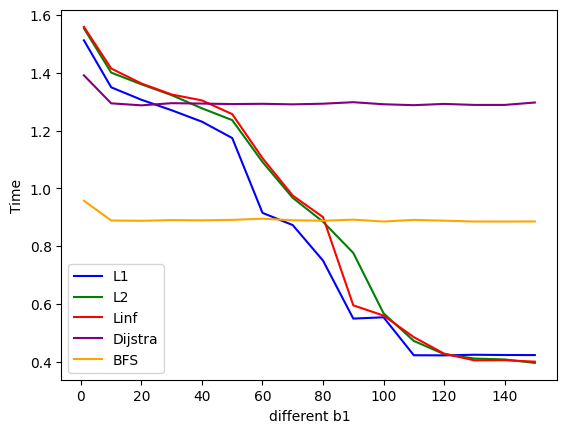

In [292]:
import matplotlib.pyplot as plt
import numpy as np

x = b1s 


y1,y2,y3,y4,y5 =[],[],[],[],[]
for s in times:
    y1.append(s[0])
    y2.append(s[1])
    y3.append(s[2])
    y4.append(s[3])
    y5.append(s[4])
    
plt.plot(x, y1, label='L1', color='blue')
plt.plot(x, y2, label='L2', color='green')
plt.plot(x, y3, label='Linf', color='red')
plt.plot(x, y4, label='Dijstra', color='purple')
plt.plot(x, y5, label='BFS', color='orange')

plt.xlabel('different b1')
plt.ylabel('Time')
plt.legend()

plt.show()


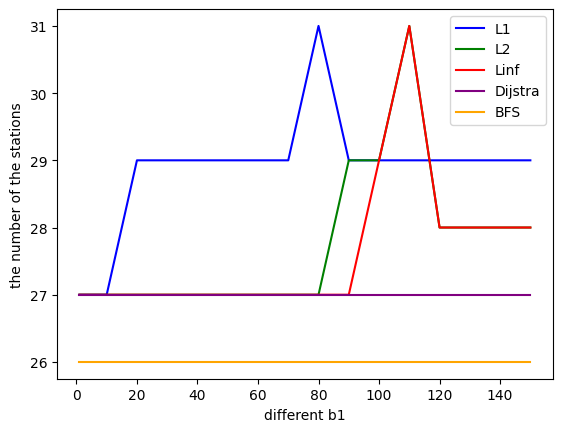

In [293]:
x = b1s 

y1,y2,y3,y4,y5 =[],[],[],[],[]
for s in numbers:
    y1.append(s[0])
    y2.append(s[1])
    y3.append(s[2])
    y4.append(s[3])
    y5.append(s[4])
    
plt.plot(x, y1, label='L1', color='blue')
plt.plot(x, y2, label='L2', color='green')
plt.plot(x, y3, label='Linf', color='red')
plt.plot(x, y4, label='Dijstra', color='purple')
plt.plot(x, y5, label='BFS', color='orange')

plt.xlabel('different b1')
plt.ylabel('the number of the stations')
plt.legend()

plt.show()


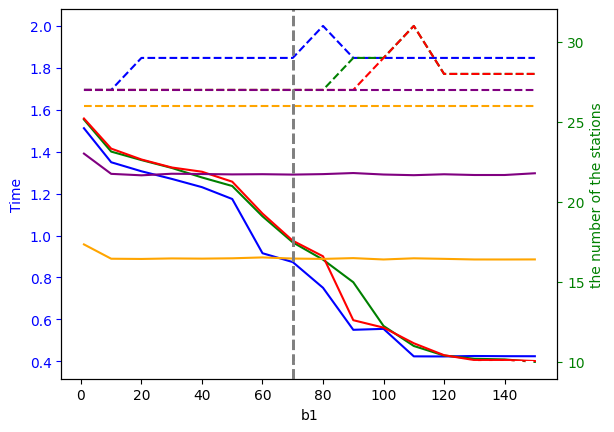

In [315]:
import matplotlib.pyplot as plt
import numpy as np

x = b1s 

y1,y2,y3,y4,y5,y6 =[],[],[],[],[],[]
for s in times:
    y1.append(s[0])
    y2.append(s[1])
    y3.append(s[2])
    y4.append(s[3])
    y5.append(s[4])
    y6.append(2)

fig, ax1 = plt.subplots()
    
ax1.plot(x, y1, label='L1', color='blue')
ax1.plot(x, y2, label='L2', color='green')
ax1.plot(x, y3, label='Linf', color='red')
ax1.plot(x, y4, label='Dijstra', color='purple')
ax1.plot(x, y5, label='BFS', color='orange')
ax1.plot(x, y6, label='basic line',color='white')

ax1.set_xlabel('b1')
ax1.set_ylabel('Time', color='blue')
ax1.tick_params('y', colors='blue')

ax2 = ax1.twinx()

y1,y2,y3,y4,y5,y6 =[],[],[],[],[],[]
for s in numbers:
    y1.append(s[0])
    y2.append(s[1])
    y3.append(s[2])
    y4.append(s[3])
    y5.append(s[4])
    y6.append(10)
    
ax2.plot(x, y1, label='L1',linestyle='--', color='blue')
ax2.plot(x, y2, label='L2',linestyle='--', color='green')
ax2.plot(x, y3, label='Linf',linestyle='--', color='red')
ax2.plot(x, y4, label='Dijkstra',linestyle='--', color='purple')
ax2.plot(x, y5, label='BFS', linestyle='--',color='orange')
ax2.plot(x, y6, label='basic line', linestyle='--',color='white')

ax2.set_ylabel('the number of the stations', color='green')
ax2.tick_params('y', colors='green')

ax1.axvline(x=70, color='gray', linestyle='--', linewidth=2)
ax2.axvline(x=70, color='gray', linestyle='--', linewidth=2)

plt.show()



In [295]:
a = 2
print(a)
a = 20
print(a)

2
20
